# BAYa class Assignment 2023

In this assignment, your task will be to implement and analyze inference for the Probabilistic linear discriminant analysis (PLDA) model. This model was described in the corresponding [slides from BAYa class](http://www.fit.vutbr.cz/study/courses/BAYa/public/slides/2-Graphical%20Models.pdf). You will accomplish this task by completing this Jupyter Notebook, which already comes with a code generating the training data and some plotting functions for presenting the results. If you do not have any experience with Jupyter Notebook, the easiest way to start is to install Anaconda3, run Jupyter Notebook, and open this notebook downloaded from [BAYa_Assignment2023.ipynb](http://www.fit.vutbr.cz/study/courses/BAYa/public/notebooks/BAYa_Assignment2023.ipynb). You can also find some inspiration and pieces of code to reuse in the other [Jupyter Notebooks provided for this class](http://www.fit.vutbr.cz/study/courses/BAYa/public/notebooks).

The Notebook is organized as follows:
1. First comes a cell with a code of functions that will be later used for presenting the results and the learned models. You can skip this cell first as the use of the functions will be demonstrated later.
2. Next comes a code that "handcrafts" some parameters of the PLDA model and implements the generative process assumed by the PLDA model. The code generates some artificial training data that you will use for PLDA model training. Please carefully read this code and the comments around it.
3. Through this notebook, there are cells with instructions to fill in your implementations around the PLDA model. There are also fields with other tasks to accomplish and questions to answer. 

**Do not edit the code in the following cell for generating and presenting the training data!**
 $$
 \let\DeclareMathOperator\newcommand
 \DeclareMathOperator{\E}{\mathbb{E}}
\DeclareMathOperator{\aalpha}{\boldsymbol{\alpha}}
\DeclareMathOperator{\bbeta}{\boldsymbol{\beta}}
\DeclareMathOperator{\NN}{\mathbf{N}}
\DeclareMathOperator{\ppi}{\boldsymbol{\pi}}
\DeclareMathOperator{\mmu}{\boldsymbol{\mu}}
\DeclareMathOperator{\SSigma}{\boldsymbol{\Sigma}}
\DeclareMathOperator{\llambda}{\boldsymbol{\lambda}}
\DeclareMathOperator{\diff}{\mathop{}\!\mathrm{d}}
\DeclareMathOperator{\zz}{\mathbf{z}}
\DeclareMathOperator{\ZZ}{\mathbf{Z}}
\DeclareMathOperator{\XX}{\mathbf{X}}
\DeclareMathOperator{\xx}{\mathbf{x}}
\DeclareMathOperator{\YY}{\mathbf{Y}}
\DeclareMathOperator{\NormalGamma}{\mathcal{NG}}
\DeclareMathOperator{\Tr}{Tr}
$$

In [1]:
# Run this code! But there is no need to pay much attention to this cell at the first pass through the notebook

%matplotlib inline 
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sps


def rand_gauss(n, mu, cov):
    """
    Sample n data points from multivariate Gaussian distribution with mean mu and covariance cov
    """
    return np.atleast_2d(sps.multivariate_normal.rvs(mu, cov, n))

def logpdf_gauss(x, mu, cov):
    """
    Evaluation of the log probability density function for multivariate Gaussian with mean mu and covariance cov
    """
    return sps.multivariate_normal.logpdf(x, mu, cov)
   
def gellipse(mu, cov, n=100, *args, **kwargs):
    """
    Contour plot of 2D Multivariate Gaussian distribution.

    gellipse(mu, cov, n) plots ellipse given by mean vector MU and
    covariance matrix COV. Ellipse is plotted using N (default is 100)
    points. Additional parameters can specify various line types and
    properties. See description of matplotlib.pyplot.plot for more details.
    """
    if mu.shape != (2,) or cov.shape != (2, 2):
        raise RuntimeError('mu must be a two element vector and cov must be 2 x 2 matrix')

    d, v = np.linalg.eigh(4 * cov)
    d = np.diag(d)
    t = np.linspace(0, 2 * np.pi, n)
    x = v @ np.sign(d) @ np.sqrt(np.abs(d)) @ np.array([np.cos(t), np.sin(t)]) + mu[:,np.newaxis]
    return plt.plot(x[0], x[1], *args, **kwargs)

def probit(a):
    from scipy.special import erfinv
    return np.sqrt(2.0) * erfinv(2.0 * a - 1.0)

def plot_det(tar, non, label="",
             axis = [0.2, 40, 0.2, 80],
             xticks = [0.2, 0.5, 1, 2, 5, 10, 20, 35, 50, 65, 80],
             yticks = [0.2, 0.5, 1, 2, 5, 10, 20, 35, 50, 65, 80],
             **kwargs):
        """
        plots DET curve 
        """
        tar = np.array(tar)
        non = np.array(non)
        ntrue=len(tar)
        nfalse=len(non)
        ntotal=ntrue+nfalse

        Pmiss=np.zeros(ntotal+1,np.float32) # 1 more for the boundaries
        Pfa=np.zeros_like(Pmiss)

        scores=np.zeros((ntotal,2),np.float32)
        scores[0:nfalse,0]=non
        scores[0:nfalse,1]=0
        scores[nfalse:ntotal,0]=tar
        scores[nfalse:ntotal,1]=1
        scores=scores[scores[:,0].argsort(),]

        sumtrue=np.cumsum(scores[:,1])
        sumfalse=nfalse - (np.arange(1,ntotal+1)-sumtrue)

        Pmiss[0]=float(ntrue-ntrue) / ntrue
        Pfa[0]=float(nfalse) / nfalse
        Pmiss[1:]=(sumtrue+ntrue-ntrue) / ntrue
        Pfa[1:]=sumfalse / nfalse
        
        idxeer=np.argmin(np.abs(Pfa-Pmiss))
        EER = 0.5*(Pfa[idxeer]+Pmiss[idxeer])*100

        plt.plot(probit(Pfa), probit(Pmiss), label=label + ' EER=%.2f%%' % EER, **kwargs)
        plt.xticks(probit(np.array(xticks)/100), xticks)
        plt.yticks(probit(np.array(yticks)/100), yticks)
        plt.axis(probit(np.array(axis)/100))

        plt.xlabel("FA [%]", fontsize = 12)
        plt.ylabel("Miss [%]", fontsize = 12)
        plt.grid(True)
        plt.legend(loc='upper left', bbox_to_anchor=(1, 1))



## PLDA generative process

A PLDA model is often used to model speaker embeddings in the speaker verification context.
Such embeddings are obtained by means of a neural network (i.e. ResNet, TDNN, etc.) which is trained for speaker classification.
The neural network transforms variable-length input speech utterances into some fixed-length low-dimensional (i.e. 512, 1024) vector representations (e.g. the embeddings are the output of a hidden layer of the neural network).

The PLDA model assumes the following two-step generative process for the embeddings (our observations):

1.

\begin{equation}
{\mathbf{z}_s} \sim \mathcal{N}(\mathbf{z}_s;\boldsymbol{\mu},\boldsymbol{\Sigma}_{ac}) \quad \text{for } s=1, \dots, S
\end{equation}

where, $\mathbf{z}_s$ is the continuous latent random variable representing the speaker-specific mean for speaker $s$, $\boldsymbol{\mu}$ is the global speaker mean, $\boldsymbol{\Sigma}_{ac}$ is the across-class (across-speaker) covariance matrix.


2.

\begin{equation}
{\mathbf{x}_{sn}} \sim \mathcal{N}(\mathbf{x}_{sn};\mathbf{z}_{s},\boldsymbol{\Sigma}_{wc}) \quad \text{for } n=1, \dots, N_s
\end{equation}

where, $\mathbf{x}_{sn}$ is the continuous random variable representing observations specific to speaker $s$ (per-speaker embeddings), $N_s$ is the number of observations (embeddings) for spearker $s$, $\mathbf{z}_s$ is the mean for speaker $s$,  and $\boldsymbol{\Sigma}_{wc}$ is the within-class (within-speaker) covariance matrix, which is shared among (the same for) all speakers.


Therefore, we assume that $S$ speaker means were generated from a Gaussian distribution $\mathcal{N}(\mathbf{z}_s;\boldsymbol{\mu},\boldsymbol{\Sigma}_{ac})$, and then $N_s$ embeddings were generated for each of such speakers from the Gaussian distribution $\mathcal{N}(\mathbf{x}_{sn};\mathbf{z}_{s},\boldsymbol{\Sigma}_{wc})$. This process can also be visulized in the Bayesian Network shown below.

Obviously, this assumption is something we make up when defining our model, as the embeddings were generated by the neural network, and not by such PLDA model.


<div>
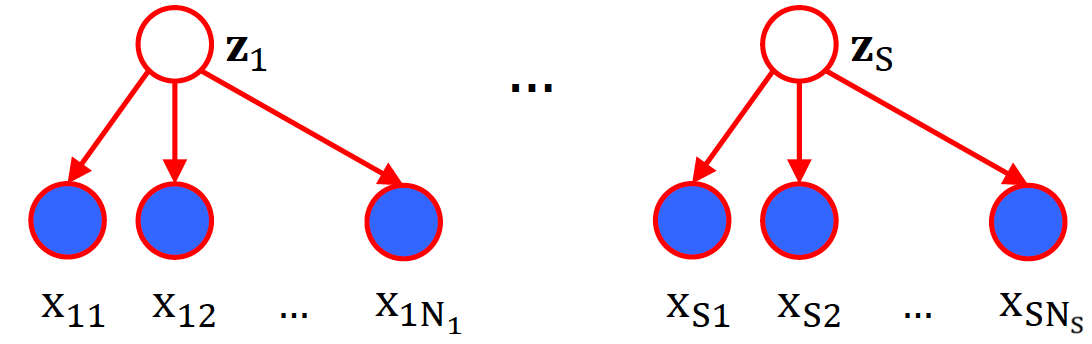
</div>

## Joint probability:

Given the definition of the PLDA model, we can now write the joint probability of all observed variables $\XX$ and latent variables $\ZZ$, where it should be straighforward to see that the joint probability factorizes per speaker (see the Bayesian network).

Let $\XX=[\XX_1,\XX_2,...,\XX_S]$, where $\XX_s = [\xx_{s1}, \xx_{s2}, \dots, \xx_{sN_s} ]$contain the set of training observations of speaker $s$. Similarly, $\ZZ=[\zz_1,\zz_2,...,\zz_S]$.

Then, the joint probability is: 

$$P(\XX, \ZZ) 
= \prod_{s=1}^S p(\XX_s,\zz_s)
= \prod_{s=1}^S \left( p(\zz_s) \prod_{n=1}^{N_s} p(\xx_{sn}|\zz_s) \right)$$

$$\ln P(\XX, \ZZ) 
= \sum_{s=1}^S \ln p(\XX_s,\zz_s)
= \sum_{s=1}^S \ln p(\zz_s) + \sum_{n=1}^{N_s} \ln p(\xx_{sn}|\zz_s)$$



## Handcrafting the PLDA model

In order to generate some artificial training data, we will handcraft a *ground truth* PLDA model.
We will handcraft the global ground truth speaker mean $\boldsymbol\mu^{GT}$, and the covariance matrices $\boldsymbol{\Sigma}_{ac}^{GT}$ and $\boldsymbol{\Sigma}_{wc}^{GT}$. 
We will generate our training data using this PLDA model, and we hope to learn it back (or some close to it) during the PLDA model training. 
In order to be able to draw, visualize and interpret our models, we consider only a toy example with $D=2$ dimensional data.

The cell below handcrafts the PLDA model and plots its parameters. In the plot, the dot corresponds to the global mean, the blue elipse is the coutour plot of $\mathcal{N}(\mathbf{z}_s;\boldsymbol{\mu},\boldsymbol{\Sigma}_{ac}^{GT})$ and the red elipse is the countour plot of $\mathcal{N}(\mathbf{x}_{sn};\mathbf{0},\boldsymbol{\Sigma}_{wc}^{GT})$. The contours correspond to twice the standard deviation of the data from the mean.


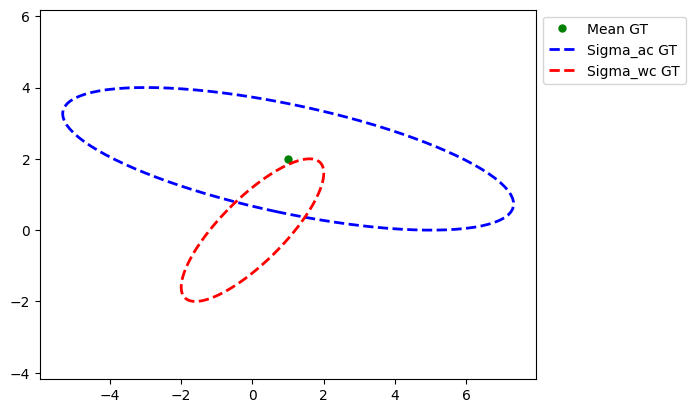

In [2]:
#Do not edit this code!
mu_gt =  np.array([1, 2]) #ground truth global mean
Sigma_wc_gt = np.array([[1, 0.8], #ground truth within class covariance
                     [0.8, 1]])

Sigma_ac_gt = np.array([[10, -2], #ground truth across class covariance
                     [-2, 1]])

def plotPLDA(mu, Sigma_ac, Sigma_wc, marker_mu, line_style_Sigmas, name):
    """
    plot of a PLDA model that shows: 
    the global mean mu in green,
    the across-class covariance Sigma_ac in blue, 
    and the within-class covariance Sigma_wc centered around [0,0] in red.
    Possible markers for mu are: '.','o','x' (see https://matplotlib.org/stable/api/markers_api.html)
    Possible line_styles for the countours are: '--', ':', '-'
    name refers to the name of the PLDA model to be displayed in the legend
    
    """
    assert marker_mu in {"." , "o" , "x"}
    assert line_style_Sigmas in {"--" , ":" , "-"}
    
    plt.plot(mu[0], mu[1], 'g'+marker_mu, ms=10, label='Mean '+name) 
    gellipse(mu, Sigma_ac, 100, 'b'+line_style_Sigmas, lw=2, label='Sigma_ac '+name)
    gellipse(np.array([0,0]), Sigma_wc, 100, 'r'+line_style_Sigmas, lw=2, label='Sigma_wc '+name) #for mere visualization purposes, we center the within-class covariance on the origin (0,0)
    plt.axis('equal')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

plotPLDA(mu_gt,Sigma_ac_gt,Sigma_wc_gt,'.','--','GT')

## Sampling training data
Once we have the global mean and the matrices $\boldsymbol\Sigma_{ac}^{GT}$ and $\boldsymbol\Sigma_{wc}^{GT}$, we can sample speakers and their corresponding embeddings.
We sample $S=10$ speaker means and then their corresponding embeddings, where we sample a different number of embeddings per speaker. For now, we consider a rather extreme case with only one or two samples per speaker.

Besides sampling the data, the code below plots the countour of $\mathcal{N}(\mathbf{z}_s;\boldsymbol{\mu},\boldsymbol{\Sigma}_{ac}^{GT})$, the sampled speaker means $\zz_s$, the countour of the per-speaker embedding distribution $\mathcal{N}(\mathbf{x}_{sn};\zz_s,\boldsymbol{\Sigma}_{wc}^{GT})$ and the per-speaker embeddings sampled from this distribution.



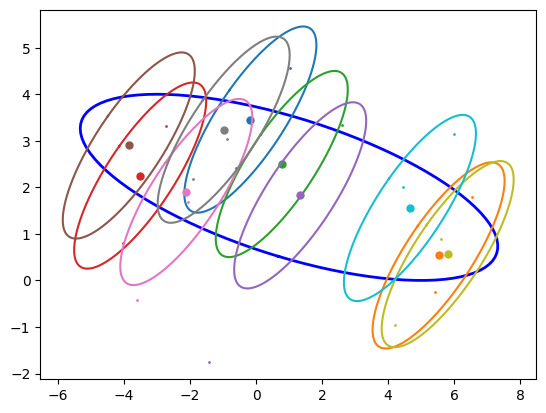

In [3]:
#Do not edit this code!
def sample_from_PLDA(mu, Sigma_ac, Sigma_wc, S, min_samples_per_speaker, max_samples_per_speaker):
    """
    Generate samples from a PLDA distribution, where each speaker can have a different number of samples:
    mu: global mean
    Sigma_ac: across-class covariance matrix
    Sigma_wc: within-class covariance matrix
    S: Number of speakers to be sampled
    min_samples_per_speaker: minimum number of observations to be sampled for a speaker
    max_samples_per_speaker: maximum number of observations to be sampled for a speaker
    
    Returns:
    Z: two dimensional array where each row is a sampled speaker mean
    X: list of two dimensional arrays, where rows of each array are the individual observations per speaker
    """
    N = np.random.randint(min_samples_per_speaker, max_samples_per_speaker+1, S) # Number of observations per speaker
    Z =  rand_gauss(S, mu, Sigma_ac) # speaker means
    X = [] # Collection of all the X_s

    # For each speaker
    for ns, z in zip(N, Z):
        X_s = rand_gauss(ns, z, Sigma_wc)
        X.append(X_s)
    return X, Z   #Recall, that we do not return N, which can be easily derived from X

#Sampled training data for 10 speakers with only one or two samples per speaker:
X, Z = sample_from_PLDA(mu_gt, Sigma_ac_gt, Sigma_wc_gt, S=10, min_samples_per_speaker=1, max_samples_per_speaker=2)

gellipse(mu_gt, Sigma_ac_gt, 100, 'b', lw=2)
for X_s, z in zip(X, Z):
    p = plt.plot(X_s[:,0], X_s[:,1], '.', ms=2)
    c = p[0].get_color()
    plt.plot(z[0], z[1], '.', c=c, ms=10)
    gellipse(z, Sigma_wc_gt, 100, c=c)
    


# Simple maximum-likelihood estimate of parameters

We can estimate the parameters of the PLDA model using the following formulas (which are the same as the ones used in the linear distriminant analysis or linear Gaussian classifier from SUR classes).

$N =  \sum_{s=1}^S N_s$

$\overline{\mmu} = \frac{1}{N} \sum_{s=1}^S \sum_{n=1}^{N_s} \xx_{sn}$

$\overline{\mmu}_s = \frac{1}{N_s} \sum_{n=1}^{N_s} \xx_{sn}$

$\overline{\SSigma}_{ac} = \frac{1}{N} \sum_{s=1}^S N_s \left(\overline{\mmu}_s-\overline{\mmu}\right)\left(\overline{\mmu}_s-\overline{\mmu}\right)^T$

$\overline{\SSigma}_{wc} = \frac{1}{N} \sum_{s=1}^S N_s \underbrace{\left(\frac{1}{N_s} \sum_{n=1}^{N_s} \left(\xx_{sn}-\overline{\mmu}_s\right)\left(\xx_{sn}-\overline{\mmu}_s\right)^T\right)}_{\overline{\Sigma}_s}$



### Task 1 

- Implement these simple maximum-likelihood estimates for the PLDA parameters. To do so, complete the *simple_PLDA_estimate* function defined below.
- Next, plot (in the same plot) the obtained PLDA parameters and the ground truth PLDA model parameters. Use the function *plotPLDA* defined above with different markers and line styles for a proper visualization.

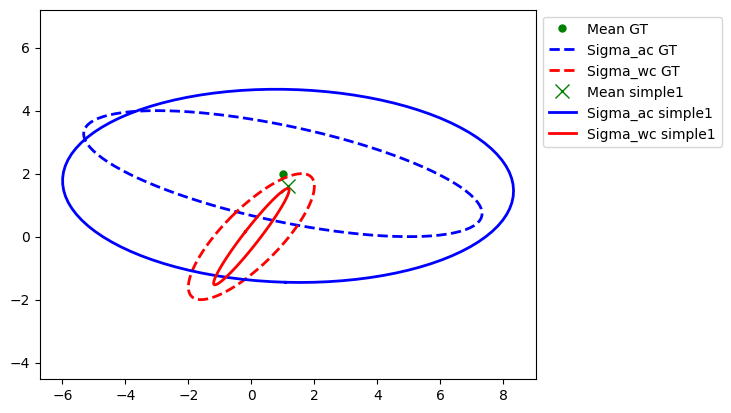

In [4]:
def simple_PLDA_estimate(X):
    """
    Estimates the PLDA parameters using the simple maximum-likelihood approach:
    - X: whole set of training embeddings (for all speakers) as a list of two dimensional arrays, 
         where rows of each array are the individual observations per speaker
    
    Returns:
    - mu: global mean
    - Sigma_ac: across-class covariance matrix
    - Sigma_wc: within-class covariance matrix
    """
    
    # your code goes here
    N_s = np.array([len(X_s) for X_s in X])
    N = np.sum(N_s)
    X_s_sums = [np.sum(X_s, axis=0) for X_s in X]
    mu = np.sum(X_s_sums, axis=0) / N
    mu_s = X_s_sums / N_s.reshape(-1, 1)
    mu_s_minus_mu = mu_s - mu
    Sigma_ac = np.sum((mu_s_minus_mu.reshape(-1, 2, 1) @ mu_s_minus_mu.reshape(-1, 1, 2)) * N_s.reshape(-1, 1, 1), axis=0) / N
    X_minus_mu_s = [X_s - mu_s_el for X_s, mu_s_el in zip(X, mu_s)]
    #Sigma_wc = np.sum([(np.sum(X_s_minus_mu_s.reshape(-1, 2, 1) @ X_s_minus_mu_s.reshape(-1, 1, 2), axis=0) / N_s_el) * N_s_el for X_s_minus_mu_s, N_s_el in zip(X_minus_mu_s, N_s)], axis=0) / N
    Sigma_wc = np.sum([np.sum(X_s_minus_mu_s.reshape(-1, 2, 1) @ X_s_minus_mu_s.reshape(-1, 1, 2), axis=0) for X_s_minus_mu_s in X_minus_mu_s], axis=0) / N
    
    return mu, Sigma_wc, Sigma_ac

#Make use of the following variable names
mu_simple1, Sigma_wc_simple1, Sigma_ac_simple1 = simple_PLDA_estimate(X)



#code for plots goes here
plotPLDA(mu_gt, Sigma_ac_gt, Sigma_wc_gt, '.', '--', 'GT')
plotPLDA(mu_simple1, Sigma_ac_simple1, Sigma_wc_simple1, 'x', '-', 'simple1')


# PLDA Expectation Maximization training

With EM, we can get better estimate of the parameters than with the *naive* simple maximum-likelihood estimates.

Your first task here will be to derive some of the math related to the expectation-maximization updates for PLDA model training.
Below we provide the framework for such derivations.


## Summary of the EM algorithm

The EM algorithm makes use of the following formula to find the parameters that maximize the likelihood of the data:




$\ln p(\mathbf{\XX}|\boldsymbol{\eta}) = 
\underbrace{\sum_{\ZZ}q(\ZZ) \ln p(\XX,\ZZ)|\boldsymbol{\eta})}_{\mathcal{Q}(q(\ZZ),\eta)}
\underbrace{-\sum_{\ZZ}q(\ZZ) \ln q(\ZZ)}_{H(q(\ZZ))}
\underbrace{-\sum_{\ZZ} q(\ZZ) \ln \frac{p(\ZZ | \XX,\boldsymbol{\eta})}{q(\ZZ)}}_{D_{KL}(q(\ZZ)||p(\ZZ|\XX,\eta)}$

The steps for the EM algorithm are:
1. Initialize parameters of the model (e.g. randomly or to constant values).
2. E-step, set $q(\ZZ):=p(\ZZ|\XX,\eta)$, to make the Kullback-Liebler divergence 0
3. M-step, having fixed $q(\ZZ)$, optimize the parameters of the PLDA model to maximize the auxiliary function $\mathcal{Q}$ (and maximize therefore the likelihood of the data)





## E-step
In the E-step, we need to set $q(\ZZ):=p(\ZZ|\XX,\eta)$. 
By looking at the Bayesian network we can see that the posterior distribution of the latent variable  factorizes as $p(\ZZ|\XX,\eta)= \prod_s p(\mathbf{z}_s|\mathbf{X}_s,\eta)$.  Therefore $q(\ZZ)=\prod_s q(\zz_s)$ where we set $ q(\zz_s):=  p(\mathbf{z}_s|\mathbf{X}_s,\eta)$, which can be calculated as:


$$ p(\zz_s | \XX_s, \eta) 
=  \mathcal{N}(\zz_s;\mmu_s,\SSigma_s)$$ 

$$ \mmu_s = \SSigma_s \left(\SSigma_{ac}^{-1}\mmu + \SSigma_{wc}^{-1} \sum_{n=1}^{N_s}\xx_{sn}\right)  \hspace{2cm} \SSigma_s = \left(\SSigma_{ac}^{-1} + N_s \SSigma_{wc}^{-1} \right)^{-1}
$$


### Task 2: 
Complete the derivations of the E-step to obtain the formulas above. Start from the expression given below (but check the tips given after it).

$$
\begin{align}
\ln p(\zz_s | \XX_s, \eta) 
&= \ln p(\XX_s,\zz_s) + const. \\
&= \ln \left[ p(\zz_s) \prod_{n=1}^{N_s} p(\xx_{sn}|\zz_s) \right] + const. \\
&= \ln p(\zz_s) + \ln \prod_{n=1}^{N_s} p(\xx_{sn}|\zz_s) + const. \\
&= \ln p(\zz_s) + \sum_{n=1}^{N_s} \ln p(\xx_{sn}|\zz_s) + const. \\
&= \ln \mathcal{N}(\zz_s;\mmu,\SSigma_{ac}) + \sum_{n=1}^{N_s} \ln \mathcal{N}(\xx_{sn}; \zz_s, \SSigma_{wc}) + const. \\
&= -\frac{1}{2} \zz_s^T \SSigma_{ac}^{-1} \zz_s + \zz_s^T \SSigma_{ac}^{-1} \mmu + \sum_{n=1}^{N_s} \left( -\frac{1}{2} \xx_{sn}^T \SSigma_{wc}^{-1} \xx_{sn} + \xx_{sn}^T \SSigma_{wc}^{-1} \zz_s \right) + const. \\
&= -\frac{1}{2} \zz_s^T \SSigma_{ac}^{-1} \zz_s + \zz_s^T \SSigma_{ac}^{-1} \mmu + \sum_{n=1}^{N_s} -\frac{1}{2} \xx_{sn}^T \SSigma_{wc}^{-1} \xx_{sn} + \sum_{n=1}^{N_s} \xx_{sn}^T \SSigma_{wc}^{-1} \zz_s + const. \\
&= -\frac{1}{2} \zz_s^T \SSigma_{ac}^{-1} \zz_s + \zz_s^T \SSigma_{ac}^{-1} \mmu + \sum_{n=1}^{N_s} \xx_{sn}^T \SSigma_{wc}^{-1} \zz_s + const. \\
&= -\frac{1}{2} \zz_s^T \SSigma_{ac}^{-1} \zz_s + \zz_s^T \SSigma_{ac}^{-1} \mmu + \sum_{n=1}^{N_s} \zz_s^T \SSigma_{wc}^{-1} \xx_{sn} + const. \\
&= -\frac{1}{2} \zz_s^T \SSigma_{ac}^{-1} \zz_s + \zz_s^T \SSigma_{ac}^{-1} \mmu + \zz_s^T \SSigma_{wc}^{-1} \sum_{n=1}^{N_s} \xx_{sn} + const. \\
&= -\frac{1}{2} \zz_s^T \SSigma_{ac}^{-1} \zz_s + \zz_s^T \left( \SSigma_{ac}^{-1} \mmu + \SSigma_{wc}^{-1} \sum_{n=1}^{N_s} \xx_{sn} \right) + const. \\
&= TODO \\
&... \color{red}{write\ your\ derivations\ here}\\
\end{align}
$$

<div class="alert alert-block alert-info"><b>Tip: </b> To complete the derivation, it might be useful to understand what is the "completion of squares" method:


For any Gaussian distribution $\mathcal{N}(\mathbf{y};\mmu_o,\SSigma_o)$, the following holds: 

$$\ln \mathcal{N}(\mathbf{y};\mmu_o,\SSigma_o) = -\frac{D}{2} \ln (2\pi)-\frac{1}{2} \ln|\SSigma_o|-\frac{1}{2} (\mathbf{y}-\mmu_o)^T\SSigma_o^{-1}(\mathbf{y}-\mmu_o) $$

Given that it is a function of the random variable $\mathbf{y}$, we can consider:
    
$$= -\frac{1}{2} \mathbf{y}^T \SSigma_o^{-1} \mathbf{y} + \mathbf{y}^T \SSigma_o^{-1}\mmu_o + const.$$
    
where $const$ is a constant encompassing all terms independent of $\mathbf{y}$.
    
Therefore, if you obtain an expression in the form:

$$-\frac{1}{2} \mathbf{y}^T A \mathbf{y} + \mathbf{y}^T B$$

and you know that it corresponds to a valid probability distribution (up to the missing constant term) then it corresponds to the log of a (unnormalized) Gaussian distribution where $A$ and $B$ will be the terms $A=\SSigma_o^{-1}$ and $B=\SSigma_o^{-1}\mmu_o$. 
That is, it corresponds to $\ln \mathcal{N}(\mathbf{y};A^{-1}B, A^{-1})$.
</div>
    

    




## M-step
In the M-step, we keep $q(\mathbf{z}_s)$ fixed and we optimize the parameters of the model to maximize the auxliliary function.

### Task 3: 
Complete the derivation for the M-step.
**Explain** the different steps taken.
Start from the expression below, where the first steps are given, as well as the final solution:

$
\small
\begin{align}
\mathcal{Q} 
&= \int q(\ZZ) \ln p(\XX,\ZZ) \diff \ZZ \\
&= \int \dots \int \left(\prod_{s=1}^S q(\zz_s)\right) \sum_{s=1}^S \left(\ln p(\zz_s) + \sum_{n=1}^{N_s} \ln p(\xx_{sn}|\zz_s)\right) \diff\zz_1 \dots \diff \zz_S \\
\end{align}
$

Given the factorization over components (see slide 28 from [EM algorithm](https://www.fit.vutbr.cz/study/courses/BAYa/public/slides/3-EM%20algorithm.pdf)):

$
\small
\begin{align}
\mathcal{Q}&= \sum_{s=1}^S \int q(\zz_s) \left(\ln p(\zz_s) + \sum_{n=1}^{N_s} \ln p(\xx_{sn}|\zz_s)\right) \diff\zz_s\\
& ... \color{red}{write\ your\ derivations\ here\ to\ obtain:}\\
\end{align}
$

$
\scriptsize
\begin{align}
&\mathcal{Q} = -\frac{1}{2} \sum_{s=1}^S \left(
-\ln |\SSigma_{ac}^{-1}| + \Tr\left(\SSigma_s \SSigma_{ac}^{-1}\right) +\left(\mmu_s-\mmu\right)^T\SSigma_{ac}^{-1}\left(\mmu_s-\mmu\right) + \sum_{n=1}^{N_s}\left(-\ln |\SSigma_{wc}^{-1}| + \Tr\left(\SSigma_s\SSigma_{wc}^{-1}\right) +\left(\xx_{sn}-\mmu_s\right)^T\SSigma_{wc}^{-1}\left(\xx_{sn}-\mmu_s\right)\right)\right) + const. \\
\end{align}
$




<div class="alert alert-block alert-info"><b>Tip: </b> 
Given a probability density function $q(\mathbf{y})$, we define the expected values as:

$$ \E[\mathbf{y}] = \int q(\mathbf{y}) \mathbf{y} d\mathbf{y} $$

$$ \E[f(\mathbf{y})] = \int q(\mathbf{y}) f(\mathbf{y}) d\mathbf{y} $$

The expected values have (among others) the following properties:
   
$\E[X+Y]=\E[X]+\E[Y]$
    
$\E[aX]=a\E[X]$
    
For a Gaussian distribution $q(\mathbf{y})=\mathcal{N}(\mathbf{y};\mmu_o,\SSigma_o)$, it holds:

(1) $\E[\mathbf{y}] = \mmu_o$

(2) $\E[\mathbf{y}\mathbf{y}^T]=\SSigma_o+\mmu_o\mmu_o^T$

(3) $\E[\mathbf{y}^TA\mathbf{y}]=Tr(A\SSigma_o)+\mmu_o^TA\mmu_o$

where the operator $\Tr$ refers to $trace$, the sum of elements on the main diagonal of a matrix, which has the following properties:

$\Tr(A+B)=\Tr(A)+\Tr(B)$

$\Tr(ABC)=\Tr(CAB)=\Tr(BCA)$

In the derivations, you can make use of the results and properties defined above. If used, reference them in the explanations of the derivation.
    
Most of these $tricks$ and many others can be found in [The matrix cookbook]( https://www.math.uwaterloo.ca/~hwolkowi/matrixcookbook.pdf). If you use this book for any step of the derivations, reference the corresponding formula in the text. 
</div>

### Task 4
Now, using the expression of the auxiliary function $\mathcal{Q}$ provided above, derive the updates of $\mmu$ and $\SSigma_{ac}$ and $\SSigma_{wc}$.
Again, we provide the solution for these updates and you need to take the derivative of $\mathcal{Q}$ with respect to each of the PLDA parameters, set it equal to 0 and solve for the corresponding parameters to get to such solutions.

Recall, that even if you failed to complete the previous derivations you can proceed with this one.


$
\begin{align}
&\frac{\partial \mathcal{Q}}{\partial \mmu}
= \color{red}{write\ your\ derivations\ here}\\
&\implies \mmu := \frac{1}{S} \sum_{s=1}^S \mmu_s
\end{align}
$

$
\begin{align}
&\frac{\partial \mathcal{Q}}{\partial \SSigma_{ac}^{-1}}
=\color{red}{write\ your\ derivations\ here}\\
&\implies \SSigma_{ac} := \frac{1}{S} \sum_{s=1}^S \SSigma_s + \frac{1}{S} \sum_{s=1}^S \left(\mmu_s-\mmu\right)\left(\mmu_s-\mmu\right)^T
\end{align}
$

$
\begin{align}
&\frac{\partial \mathcal{Q}}{\partial \SSigma_{wc}^{-1}}
= \color{red}{write\ your\ derivations\ here}\\
&\implies \SSigma_{wc} := \frac{1}{\sum_{s=1}^S N_s} \sum_{s=1}^S N_s \left(\SSigma_s + \frac{1}{N_s} \sum_{n=1}^{N_s} \left(\xx_{sn}-\mmu_s\right)\left(\xx_{sn}-\mmu_s\right)^T\right)
\end{align}
$


<div class="alert alert-block alert-info"><b>Tip: </b> 
Note, that to obtain the updates of the covance matrices we are suggesting to take the derivative the auxiliary function $\mathcal{Q}$ with respect to the inverse of the covariance matrices. This results in somewhat simpler derivation of the updates. 
But (if you want to show off), you can start with the derivative with respect to the (non-inverse) covariance matrices, which leads to the same result.
    
</div>

### Task 5
Using the formulas for the updates of the E and M step provided above, implement the EM algorithm for PLDA model training.

- Initialize the PLDA parameters using the simple ML estimates you obtained above.
- Fill in your implementation for the function *p_z_given_X*, which calculates the parameters $\mmu_s$, $\SSigma_s$ of the posterior distribution $p(\zz_s|\XX_s) = \mathcal{N}(\zz_s;\mmu_s,\SSigma_s)$ (E-step). Read carefully the information about the format of the input and output data.
- Implement the EM algorithm as the function *EM_PLDA_estimate*. Again, check the template of such function and the format for the inputs and outputs.
- Run the algorithm for 100 iterations. 
- Plot (in the same plot) using again the function *plotPLDA*:
    - The parameters of the PLDA model trained with EM
    - The parameters of the PLDA model obtained with simple ML
    - The parameters of the ground truth PLDA model 

Answer the following questions:
1. Is there something that the simple ML algorithm fails to do well as compared to the EM algorithm?
2. How can you draw such conclusion from the plot? 
3. How do you explain the different behaviour of the two training algorithms?



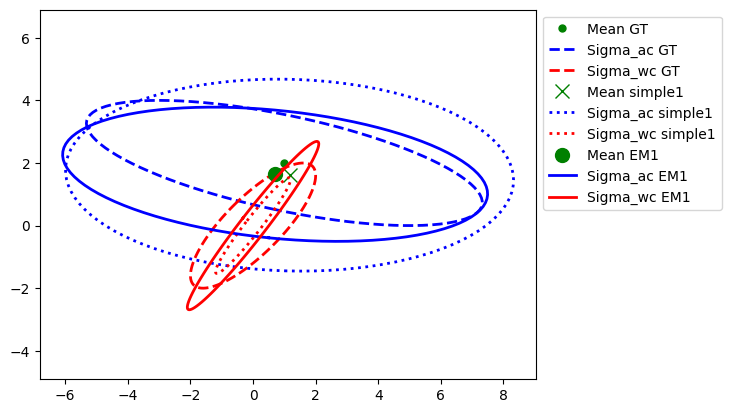

In [5]:
def p_z_given_X(X, mu, Sigma_ac, Sigma_wc):
    """
    For each speaker 's' in the input data X, it calculates the parameters of the posterior distribution 
    p(z_s|X_s)= N(z_s|mu_s,Sigma_s). For each speaker such parameters are mean (mu_s) 
    and covariance matrix (Sigma_s). The function returns the list of such means (one per speaker) 
    and the list of such covariance matrices (one per speaker).
    
    Inputs:
    - X: whole set of embeddings (for all speakers) 
    - mu: global mean
    - Sigma_ac: across-class covariance matrix
    - Sigma_wc: within-class covariance matrix   
    
    Returns:
    - mu_s: list of per-speaker posterior distribution means 
    - Sigma_s: list of per-speaker posterior distribution means covariance matrices
    """
    
    # Your code goes here
    Sigma_s = []
    mu_s = []
    Sigma_ac_inv = np.linalg.inv(Sigma_ac)
    Sigma_wc_inv = np.linalg.inv(Sigma_wc)
    
    for X_s in X:
        Sigma_s_el = np.linalg.inv(Sigma_ac_inv + len(X_s) * Sigma_wc_inv)
        Sigma_s.append(Sigma_s_el)
        mu_s_el = Sigma_s_el @ (Sigma_ac_inv @ mu + Sigma_wc_inv @ np.sum(X_s, axis=0))
        mu_s.append(mu_s_el)
    
    return mu_s, Sigma_s
    
    
    
def EM_PLDA_estimate(X, mu_init, Sigma_ac_init, Sigma_wc_init, niters):
    """
    Runs expectation-maximization algorithm for PLDA parameter estimation, where the input parameters are:
    - X: whole set of embeddings (for all speakers)
    - mu_init: initialization for the global mean
    - Sigma_ac_init: initialization for the across-class covariance
    - Sigma_wc_init: initialization for the within-class covariance
    - niters: number of EM iterations 
    
    Returns the EM estimates of:
    - mu: global mean
    - Sigma_ac: across-class covariance matrix
    - Sigma_wc: within-class covariance matrix
    """

    # Your code goes here
    mu = mu_init
    Sigma_ac = Sigma_ac_init
    Sigma_wc = Sigma_wc_init
    S = len(X)
    N_s = [len(X_s) for X_s in X]
    N = sum(N_s)

    while(niters > 0):
        mu_s, Sigma_s = p_z_given_X(X, mu, Sigma_ac, Sigma_wc)
        mu = np.sum(mu_s, axis=0) / S
        mu_s_minus_mu = mu_s - mu
        #Sigma_ac = np.sum(Sigma_s, axis=0) / S + np.sum(mu_s_minus_mu.reshape(-1, 2, 1) @ mu_s_minus_mu.reshape(-1, 1, 2), axis=0) / S
        Sigma_ac = (np.sum(Sigma_s, axis=0) + np.sum(mu_s_minus_mu.reshape(-1, 2, 1) @ mu_s_minus_mu.reshape(-1, 1, 2), axis=0)) / S
        X_minus_mu_s = [X_s - mu_s_el for X_s, mu_s_el in zip(X, mu_s)]
        Sigma_wc = np.sum([(np.sum(X_s_minus_mu_s.reshape(-1, 2, 1) @ X_s_minus_mu_s.reshape(-1, 1, 2), axis=0) / N_s_el + Sigma_s_el) * N_s_el for X_s_minus_mu_s, N_s_el, Sigma_s_el in zip(X_minus_mu_s, N_s, Sigma_s)], axis=0) / N
        niters -= 1

    return mu, Sigma_wc, Sigma_ac



# Use the following variable names for storing the PLDA model trained with EM in this task:
mu_EM1, Sigma_wc_EM1, Sigma_ac_EM1 = EM_PLDA_estimate(X, mu_simple1, Sigma_ac_simple1, Sigma_wc_simple1, 100)



#code for plots goes here
plotPLDA(mu_gt, Sigma_ac_gt, Sigma_wc_gt, '.', '--', 'GT')
plotPLDA(mu_simple1, Sigma_ac_simple1, Sigma_wc_simple1, 'x', ':', 'simple1')
plotPLDA(mu_EM1, Sigma_ac_EM1, Sigma_wc_EM1, 'o', '-', 'EM1')






### Task 6

Using the function *sample_from_PLDA*, generate a new training set from the ground truth PLDA, where you sample **1000** speakers, with 1 to 2 samples per speaker. Using the new training set:

- Re-estimate the parameters of the PLDA using both approaches, the Simple-ML and the EM algorithm. 
- Plot the parameters obtained with both methods, together with the ground truth PLDA parameters (as done before, using plotPLDA).

Questions:
1. How do the new parameter estimations compare to the previous exercise? Are parameters better estimated? If so, which ones, for which method and why? (answering only "because we have more data" is not enough)



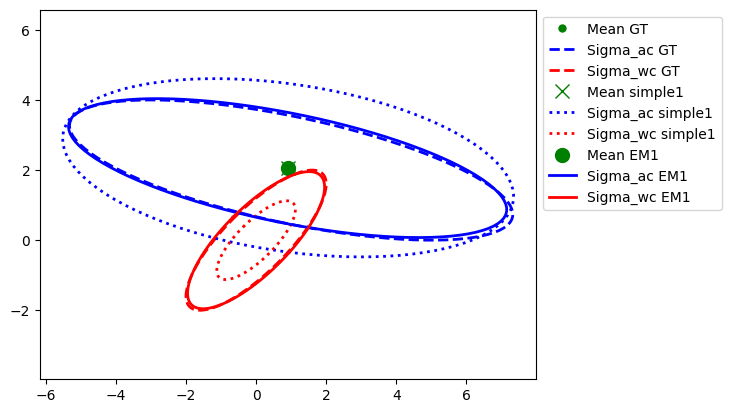

In [6]:
X, Z = sample_from_PLDA(mu_gt, Sigma_ac_gt, Sigma_wc_gt, S=1000, min_samples_per_speaker=1, max_samples_per_speaker=2) #sample_from_PLDA() 1000 speakers, with 1 to 2 samples per speaker

# Use the following variable names for storing the PLDA model trained with simple ML in this task:
mu_simple2, Sigma_wc_simple2, Sigma_ac_simple2 = simple_PLDA_estimate(X)

# Use the following variable names for storing the PLDA model trained with EM in this task:
mu_EM2, Sigma_wc_EM2, Sigma_ac_EM2 = EM_PLDA_estimate(X, mu_simple2, Sigma_ac_simple2, Sigma_wc_simple2, 100)

#code for plots goes here
plotPLDA(mu_gt, Sigma_ac_gt, Sigma_wc_gt, '.', '--', 'GT')
plotPLDA(mu_simple2, Sigma_ac_simple2, Sigma_wc_simple2, 'x', ':', 'simple1')
plotPLDA(mu_EM2, Sigma_ac_EM2, Sigma_wc_EM2, 'o', '-', 'EM1')

### Task 7
Now, repeat the same exercise with a training set where you sample 1000 speakers, with **1 to 100** samples per speaker. Show the coresponding plots and answer the same questions for this new scenario.



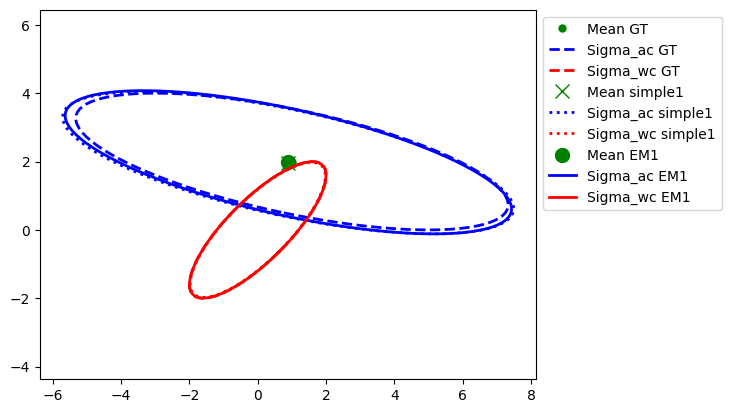

In [7]:
X, Z = sample_from_PLDA(mu_gt, Sigma_ac_gt, Sigma_wc_gt, S=1000, min_samples_per_speaker=1, max_samples_per_speaker=100) #sample_from_PLDA() 1000 speakers, with 1 to 100 samples per speaker


# Use the following variable names for storing the PLDA model trained with simple ML in this task:
mu_simple3, Sigma_wc_simple3, Sigma_ac_simple3 = simple_PLDA_estimate(X)

# Use the following variable names for storing the PLDA model trained with EM in this task:
mu_EM3, Sigma_wc_EM3, Sigma_ac_EM3 = EM_PLDA_estimate(X, mu_simple3, Sigma_ac_simple3, Sigma_wc_simple3, 100)


#code for plots goes here
plotPLDA(mu_gt, Sigma_ac_gt, Sigma_wc_gt, '.', '--', 'GT')
plotPLDA(mu_simple3, Sigma_ac_simple3, Sigma_wc_simple3, 'x', ':', 'simple1')
plotPLDA(mu_EM3, Sigma_ac_EM3, Sigma_wc_EM3, 'o', '-', 'EM1')

# PLDA Scoring

Now we will perform (simulate) speaker verification experiments, where the PLDA model will be used to evaluate speaker verification scores.

In each speaker verification experiment, we will consider independent *trials*. Each trial will consist of (one or) several enrollment embeddings $\XX_e=[\xx_1,\xx_2,...,\xx_{N_{e}}]$  generated from the same speaker and one test embedding $\xx_t$. Our task will be to answer the question of whether the test and enrollment embeddings come from the same speaker (so called *target trial*) or different speakers (*non-target trial*).


More formally, let $\mathcal{H}_s$ correspond to the hypothesis that all embeddings $\XX_e$ and $\xx_t$ are generated by the *same speaker*. 
Let $\mathcal{H}_d$ correspond to the hypothesis that the test embedding $\xx_t$ was generated by a *different speaker* than $\XX_e$.
The Bayesian networks below describe the generative process corresponding to the two hypotesis, if we assume that the embeddings were generated according to the PLDA model.



<table><tr>
<td> 
  <p align="center" style="padding: 10px">
    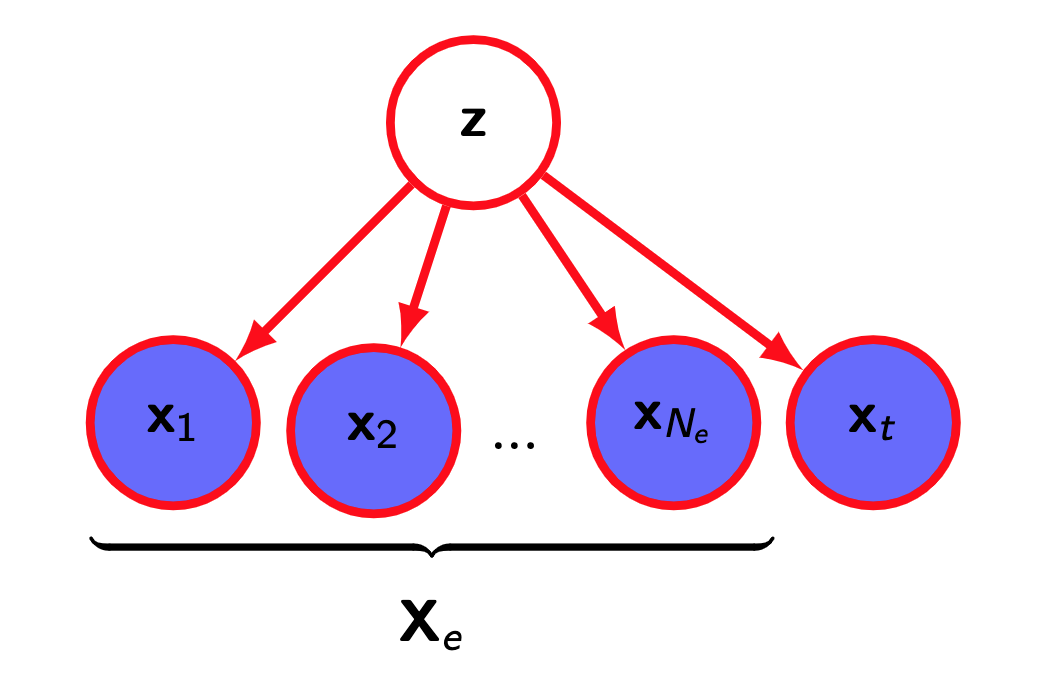
    <br>
    <em style="color: grey">Same speaker Hypothesis</em>
  </p> 
</td>
<td> 
  <p align="center">
    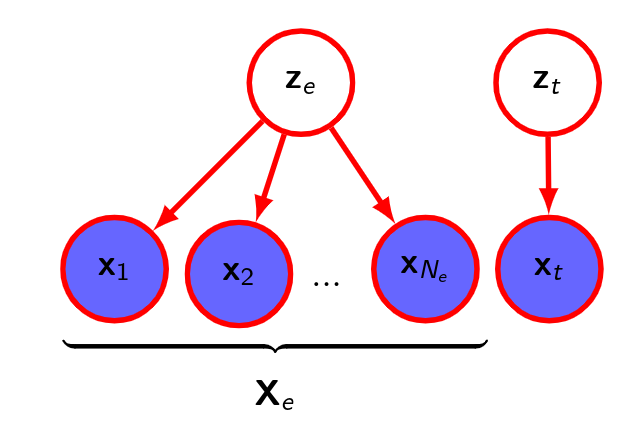
    <br>
    <em style="color: grey">Different speaker Hypothesis</em>
  </p> 
</td>
</tr></table>


From the Bayesian networks, we can easily see that the joint likelihood of the embeddings $\xx_t,\XX_e$ for the two the hypothesis can be evaluated as: 

$$p(\xx_t, \XX_e|\mathcal{H}_s)=\int p(\xx_t|\zz)p(\XX_e|\zz)p(\zz)\diff\zz$$
$$p(\xx_t, \XX_e|\mathcal{H}_d)= p(\xx_t)p(\XX_e) = \int p(\xx_t|\zz_t)p(\zz_t)\diff\zz_t\int p(\XX_e|\zz_e)p(\zz_e)\diff\zz_e$$

Intuitively, we could see the task of deciding whether the trial is a *target trial* or *non-target trial* as a binary classification task, where the two classes are the two hypothesis $\mathcal{H}_s, \mathcal{H}_d$.

Using Bayes rule, the posterior probability of the same-speaker hypothesis is:

$$P(\mathcal{H}_s|\xx_t, \XX_e) = \frac{p(\xx_t, \XX_e|\mathcal{H}_s) P(\mathcal{H}_s)}{p(\xx_t, \XX_e|\mathcal{H}_s) P(\mathcal{H}_s) + p(\xx_t, \XX_e|\mathcal{H}_d) P(\mathcal{H}_d)} = \sigma\left(LLR(\xx_t, \XX_e)+\ln\frac{P(\mathcal{H}_s)}{P(\mathcal{H}_d)}  \right),$$

where $P(\mathcal{H}_s)$ and $P(\mathcal{H}_d)=1-P(\mathcal{H}_s)$ are the prior probabilities of the two hypothesis (classes), $\sigma$ is the logistic sigmoid function and $LLR$ stands for log-likelihood ratio:

$$LLR(\xx_t, \XX_e) = \ln\frac{p(\xx_t, \XX_e|\mathcal{H}_s)}{p(\xx_t, \XX_e|\mathcal{H}_d)}.$$

However, we are not going to treat the verification task as a binary classification task considering specific priors for the two hypotheses. Instead, we will evaluate the verification performance in terms of equal error rate (EER) and using detection error tradeoff (DET) curves, as is usual in the case of verification (detection) tasks. 
For this purpose we will only need to evaluate the $LLR$ score. This score is higher (positive) when $\mathcal{H}_s$ is more likely and lower (negative) when $\mathcal{H}_d$ is more likely.

It is not easy to directly evaluate the likelihoods $p(\xx_t, \XX_e|\mathcal{H}_s)$ and $p(\xx_t, \XX_e|\mathcal{H}_d)$ from the numerator and denominator of the $LLR$, but the $LLR$ can be reformulated in terms of quantities that we already know how to evaluate:
$
\begin{align}
LLR(\xx_t, \XX_e) 
&= \ln\frac{p(\xx_t, \XX_e|\mathcal{H}_s)}{p(\xx_t, \XX_e|\mathcal{H}_d)}
= \ln\frac{\int p(\xx_t|\zz)p(\XX_e|\zz)p(\zz)\diff\zz}{p(\xx_t)p(\XX_e)}
= \ln\frac{\int p(\xx_t|\zz)\frac{p(\zz|\XX_e)p(\XX_e)}{p(\zz)}p(\zz)\diff\zz}{p(\xx_t)p(\XX_e)}
= \ln\frac{\int p(\xx_t|\zz)p(\zz|\XX_e)\diff\zz}{\int p(\xx_t|\zz)p(\zz)\diff\zz}
\color{grey}{= \ln\frac{p(\xx_t|\XX_e)}{p(\xx_t)}} \\
&= \ln\frac{\int \mathcal{N}(\xx_t;\zz,\SSigma_{wc})\mathcal{N}(\zz;\mu_e,\SSigma_e)\diff\zz}{\int \mathcal{N}(\xx_t;\zz,\SSigma_{wc})\mathcal{N}(\zz;\mmu,\SSigma_{ac})\diff\zz}
= \ln\frac{\mathcal{N}(\xx_t;\mmu_e,\SSigma_{wc}+\SSigma_e)}{\mathcal{N}(\xx_t;\mmu,\SSigma_{wc}+\SSigma_{ac})}
\end{align}
$

where the $p(\zz|\XX_e)=\mathcal{N}(\zz;\mu_e,\SSigma_e)$ is the posterior distribution of latent variable given the enrollment embeddings, which is estimated by the formula given in the E-step. 
Note that $p(\xx_t|\XX_e)$ is the posterior predictive distribution of the test embedding $\xx_t$ given that is comes from the same speaker as the enrollment embeddings $\XX_e$ and $p(\xx_t)$ is the distribution of $\xx_t$  independently generated from a random speaker.
In other words, the $LLR$ tells us whether it is more likely that the test embedding comes from the same speaker as the enrollment embeddings $\XX_e$ or from a random speaker.


To analyze and compare the performance of different systems, we use the DET curve. This curve plots miss rate in the y-axis and false alarm raten in the x-axis (using probit scales).
The point in the DER curve where miss and false alarm rate are the same is called the EER.
The function to produce such plots is provided in the first (code) cell of this BAYa project.

### Task 8

Your task now will be to implement such LLR scoring function, which we will later use it to evaluate speaker verification trials. 

- Implement the function evaluating the log-likelihood ratio scores. To do so, use the template of the function LLRs defined below and pay attention to the definition of its inputs and outputs.




In [8]:
def LLRs(x_test, X_enrol, mu, Sigma_ac, Sigma_wc):
    """Given a PLDA model, evaluates log-likelihood ratio scores for a set of N verification trials.
    Each trial consists of one test embedding and set of enrollment embeddings.
    - x_test: two dimensional array with N rows, where each row contains a test embedding from one trial 
    - X_enrol: list of N two dimensional numpy arrays. Each element in the list contains a set 
        of enrollment embeddings from one trial. Embeddings from each enrollment set are stored
        in rows of a two dimensional numpy array. 
    - mu: PLDA global mean
    - Sigma_ac: PLDA across-class covariance matrix
    - Sigma_wc: PLDA within-class covariance matrix  
    
    Returns: 
    - one dimensional numpy array containing N log-likelihood ratios.
    """
    #Your code goes here
    mu_e, Sigma_e = p_z_given_X(X_enrol, mu, Sigma_ac, Sigma_wc)
    Sigma_wc_plus_ac = Sigma_wc + Sigma_ac
    return np.array([logpdf_gauss(x_t_el, mu_e_el, Sigma_wc + Sigma_e_el) - logpdf_gauss(x_t_el, mu, Sigma_wc_plus_ac) for x_t_el, mu_e_el, Sigma_e_el in zip(x_test, mu_e, Sigma_e)])


### Task 9

Now you will generate (artificial) trials by sampling enrollment and test embeddings from the ground truth PLDA model and you will evaluate the speaker verification scores for these trials.

Your tasks are:
- Generate 20 enrollment embeddings for one random speaker.
- Generate one test embedding from the same speaker and one test embedding from a different random speaker.
- Using these generated embeddings, create now four trials:
    - Single-enrollment, target trial
    - Single-enrollment, non-target trial
    - Multi-enrollment, target trial
    - Multi-enrollment, non-target trial

    where single-enrollment refers to the case when $\XX_e$ contains a single embedding (selected from the 20 generated enrollment embeddings) and multi-enrollment refers to the case when $\XX_e$ contains all 20 generated enrollment embeddings.
- Evaluate the $LLR$ score for each such trial using the function you defined above and the *EM3* PLDA model (the PLDA model trained with EM using 1000 speakers and 1 to 100 samples per speakers). 

Questions:
1. Comment on the obtained $LLR$ values, what values did you expect and why? 
2. Are the values that you obtained in agreement with those expectations? Why?


In [10]:
# Your code for task 9 goes here
s1_multi_enrol = rand_gauss(20, Z[0], Sigma_wc_gt).reshape(1, -1, 2)
s1_multi_enrol, s1_mu = sample_from_PLDA(mu_gt, Sigma_ac_gt, Sigma_wc_gt, S=1, min_samples_per_speaker=20, max_samples_per_speaker=20)
s1_single_enrol = s1_multi_enrol[0][0].reshape(1, -1, 2)
s1_test = rand_gauss(1, s1_mu[0], Sigma_wc_gt)
s2_test = sample_from_PLDA(mu_gt, Sigma_ac_gt, Sigma_wc_gt, S=1, min_samples_per_speaker=1, max_samples_per_speaker=1)[0][0]
trial1_score = LLRs(s1_test, s1_single_enrol, mu_EM3, Sigma_ac_EM3, Sigma_wc_EM3)
trial2_score = LLRs(s2_test, s1_single_enrol, mu_EM3, Sigma_ac_EM3, Sigma_wc_EM3)
trial3_score = LLRs(s1_test, s1_multi_enrol, mu_EM3, Sigma_ac_EM3, Sigma_wc_EM3)
trial4_score = LLRs(s2_test, s1_multi_enrol, mu_EM3, Sigma_ac_EM3, Sigma_wc_EM3)

print("trial 1 score: ", trial1_score[0])
print("trial 2 score: ", trial2_score[0])
print("trial 3 score: ", trial3_score[0])
print("trial 4 score: ", trial4_score[0])

trial 1 score:  2.300723633848937
trial 2 score:  -98.51706319226878
trial 3 score:  2.416572868547719
trial 4 score:  -185.9204514792732


### Task 10

- Plot (into a single plot):
    - Embeddings:
        - All of the enrollment embeddings using black marker "."
        - The single enrollment embedding using black marker "x"
        - The target speaker test embedding as a green "*"
        - The non-target speaker test embedding as a red "*"
    - The contour of the marginal distribution $p(\xx_t)$ in black color (use gellipse function)
    - The contour of posterior distribution of the latent variable $p(\zz|\XX_e)$ for:
        - Single-enrollment $\XX_e$, blue color, dotted line
        - Multi-enrollment $\XX_e$, magenta color, dotted line  
    - The contour of the posterior predictive distribution $p(\xx_t|\XX_e)$ for:
        - Single-enrollment $\XX_e$, blue color
        - Multi-enrollment $\XX_e$, magenta color
        
Questions:
1. How do the posterior distributions $p(\zz|\XX_e)$ differ for the single and multi enrollment cases? Why?
2. How do the posterior predictive distributions $p(\xx_t|\XX_e)$ differ for the single and multi enrollment cases? Why?
3. For each of the trials from the previous tasks, look at the evaluated $LLR$ scores. Comment on how do these scores relate to what you see in this plot. Consider how the different embeddings fit different distributions in the plot. Can you see on the plot why different $LLRs$ have higher or lower values? 

<div class="alert alert-block alert-info"><b>Tip: </b> 
Note that the trials you generated in task 9 were randomly generated, and you can get unlucky and get unintuitive results. 
You might want to re-generate the trials several times (and re-run related tasks 9 and 10) to assure that you get propper understanding.
If you want, you can include outcomes of multiple such runs into the notebook and comment on the different outcomes.
</div>

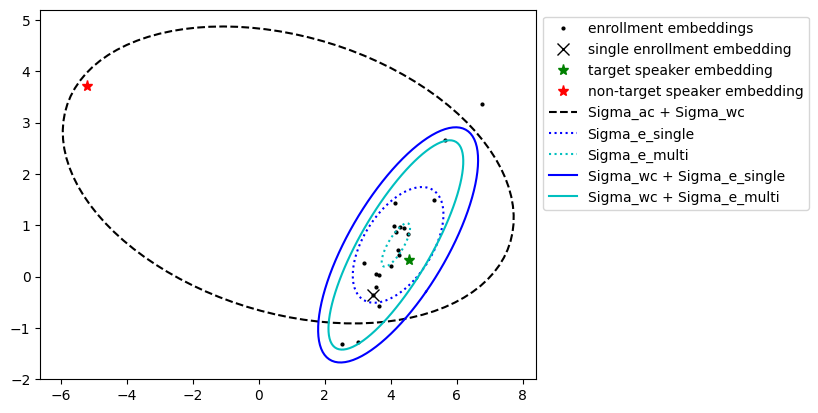

In [32]:
#Your code for the plot goes here

#recall, that the contours can be plotted using: 
#gellipse(mu, Sigma, 100, ':', c='b', label='Sigma')
# where ':' stands for for dotted line and 'b' for blue

plt.plot(s1_multi_enrol[0][:, 0], s1_multi_enrol[0][:, 1], 'k.', ms=4, label='enrollment embeddings')
plt.plot(s1_single_enrol[0, :, 0], s1_single_enrol[0, :, 1], 'kx', ms=8, label='single enrollment embedding')
plt.plot(s1_test[:, 0], s1_test[:, 1], 'g*', ms=8, label='target speaker embedding')
plt.plot(s2_test[:, 0], s2_test[:, 1], 'r*', ms=8, label='non-target speaker embedding')
gellipse(mu_EM3, Sigma_ac_EM3 + Sigma_wc_EM3, 100, '--', c='k', label='Sigma_ac + Sigma_wc')

s1_mu_e_single, s1_Sigma_e_single = p_z_given_X(s1_single_enrol, mu_EM3, Sigma_ac_EM3, Sigma_wc_EM3)
s1_mu_e_multi, s1_Sigma_e_multi = p_z_given_X(s1_multi_enrol, mu_EM3, Sigma_ac_EM3, Sigma_wc_EM3)

gellipse(s1_mu_e_single[0], s1_Sigma_e_single[0], 100, ':', c='b', label='Sigma_e_single')
gellipse(s1_mu_e_multi[0], s1_Sigma_e_multi[0], 100, ':', c='c', label='Sigma_e_multi')
gellipse(s1_mu_e_single[0], Sigma_wc_EM3 + s1_Sigma_e_single[0], 100, '-', c='b', label='Sigma_wc + Sigma_e_single')
gellipse(s1_mu_e_multi[0], Sigma_wc_EM3 + s1_Sigma_e_multi[0], 100, '-', c='c', label='Sigma_wc + Sigma_e_multi')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

## Speaker verification experiments

Now, we will simulate speaker verification experiments involving 1000 target and 1000 non-target trials. 
In the cell below, we generate:
- 10 enrollment embeddings per-speaker for 1000 different speakers. 
    - All 10 embeddings will be used for the multi-enrollment trials (variable x_enroll10)
    - We select only one of these embeddings per-speaker to create the single-enrollment trials (x_enroll1)
- 1000 target test embeddings, each corresponding to one of the enrollment speakers to form the target trials (x_test_target) 
- 1000 non-target test embeddings from 1000 random speakers to form the non-target trials (x_test_nontar)

Note that each of the target/non-target test embedding is paired with only one enrollment speaker to generate a single trial.





In [78]:
# Enrollment embedding and trial set generation. Do not edit this field!

# Note, that all generated embeddings are stored in a form compatible with the definition 
# of the LLR given above: the test embeddings are stored in rows of two dimensional arrays 
# and the enrollment embeddings (even the single-enrollment ones) are stored in a list of 
# two dimensional numpy arrays, where each element in the list contains a set of enrollment 
# embeddings.

# we sample 11 observations for 1000 speakers:
X_tar = sample_from_PLDA(mu_gt, Sigma_ac_gt, Sigma_wc_gt, S=1000, min_samples_per_speaker=11, max_samples_per_speaker=11)[0] 

# for multi-enrollment, we use the first 10 embeddings per-speaker:
x_enroll10    = [xs[:10] for xs in X_tar] 
# for single-enrollment, we use the first embedding per-speaker:
x_enroll1     = [xs[:1] for xs in X_tar] 

# the last embedding per-speaker is used as the target test embedding:
x_test_target = np.array([xs[-1] for xs in X_tar]) 

# we generate a non-target embeddings from different random speakers:
x_test_nontar = np.vstack(sample_from_PLDA(mu_gt, Sigma_ac_gt, Sigma_wc_gt, 1000, 1, 1)[0]) 


### Task 11

Let's first consider the single-enrollment trials. Your task is:
- Evaluate the $LLRs$ for target trials (target scores) by scoring the test embeddings (x_test_target) against the corresponding enrollment embedding set x_enroll1.
- Evaluate the $LLRs$ for non-target trials (non-target scores) by scoring the test embeddings (x_test_nontar) against the corresponding enrollment embedding set x_enroll1.
- Plot the histogram of such scores

Questions:
1. What can you see in the histograms? Are the verification scores useful to discriminate between target and non-target trials?

Text(0.5, 0, 'LLR score')

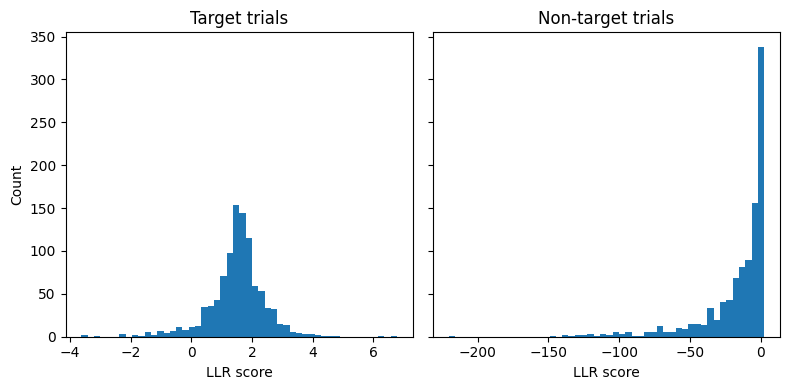

In [83]:
# Your code goes here
target_trial_scores_single = LLRs(x_test_target, x_enroll1, mu_EM3, Sigma_ac_EM3, Sigma_wc_EM3)
nontar_trial_scores_single = LLRs(x_test_nontar, x_enroll1, mu_EM3, Sigma_ac_EM3, Sigma_wc_EM3)

fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True, figsize=(8, 4))

axs[0].hist(target_trial_scores_single, 50)
axs[1].hist(nontar_trial_scores_single, 50)

axs[0].set_title("Target trials")
axs[0].set_xlabel("LLR score")
axs[0].set_ylabel("Count")
axs[1].set_title("Non-target trials")
axs[1].set_xlabel("LLR score")

### Task 12

- Repeat task 11, using for multi-enrollment trials (i.e. using x_enroll10 instead of x_enroll1)

- Plot the DET curves for both scenarios in a single plot using the plot_det function defined above (which also reports the EER)

Questions:
1. Compare the histograms of tasks 11 and 12. How are they different and why?
2. Looking now at the DET curves, how do scores of single and multi enrollment trials compare? Is this according to your intuition? Why?


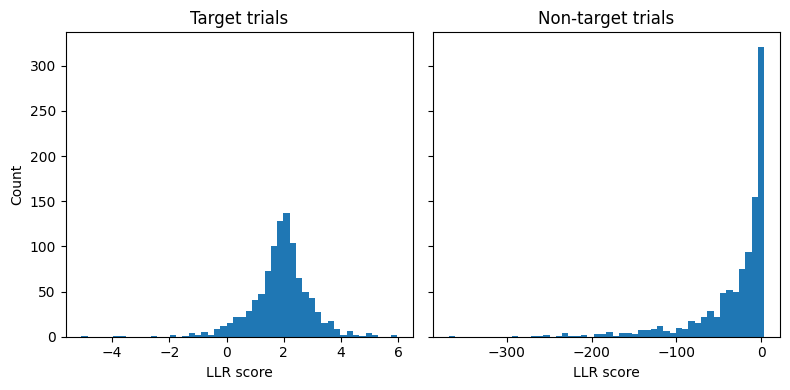

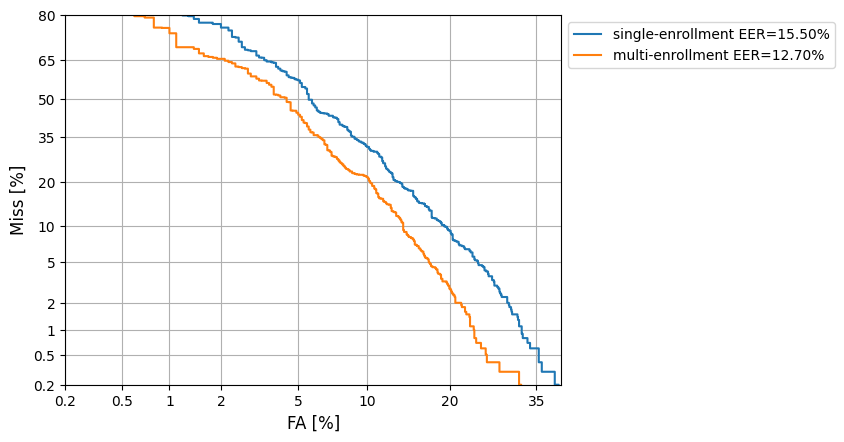

In [89]:
# Your code goes here
target_trial_scores_multi = LLRs(x_test_target, x_enroll10, mu_EM3, Sigma_ac_EM3, Sigma_wc_EM3)
nontar_trial_scores_multi = LLRs(x_test_nontar, x_enroll10, mu_EM3, Sigma_ac_EM3, Sigma_wc_EM3)

fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True, figsize=(8, 4))

axs[0].hist(target_trial_scores_multi, 50)
axs[1].hist(nontar_trial_scores_multi, 50)

axs[0].set_title("Target trials")
axs[0].set_xlabel("LLR score")
axs[0].set_ylabel("Count")
axs[1].set_title("Non-target trials")
axs[1].set_xlabel("LLR score")

plt.show()

plot_det(target_trial_scores_single, nontar_trial_scores_single, label="single-enrollment")
plot_det(target_trial_scores_multi, nontar_trial_scores_multi, label="multi-enrollment")

### Task 13

From now on, we will consider only the multi-enrollment trials.

Your tasks are: 
- Plot, in a single plot, the DET curves for the $LLRs$ obtained with the three simple ML PLDA models (*simple1*, *simple2*, *simple3*, trained with different number of speakers and number of embeddings per-speaker in tasks 1, 6 and 7) as well as the GT PLDA model. 

- Plot, in a single plot, the DET curves for the $LLRs$ obtained with the three EM PLDA models trained above (*EM1*, *EM2*, *EM3*, trained with different number of speakers and number of embeddings per-speaker in tasks 5, 6 and 7) as well as the GT PLDA model. 

Questions:
1. How does the performance of the three simple-trained PLDA models compare? What impact do the different training sets have on model's performance?
2. How does the performance of the three EM-trained PLDA models compare? What impact do the different training sets have on model's performance?
3. Does the EM algorithm have any advantage as compared to the simple ML in terms of performance? When and why?

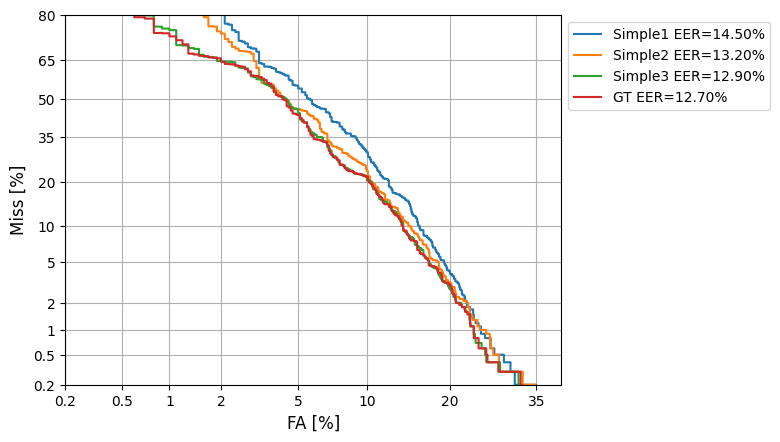

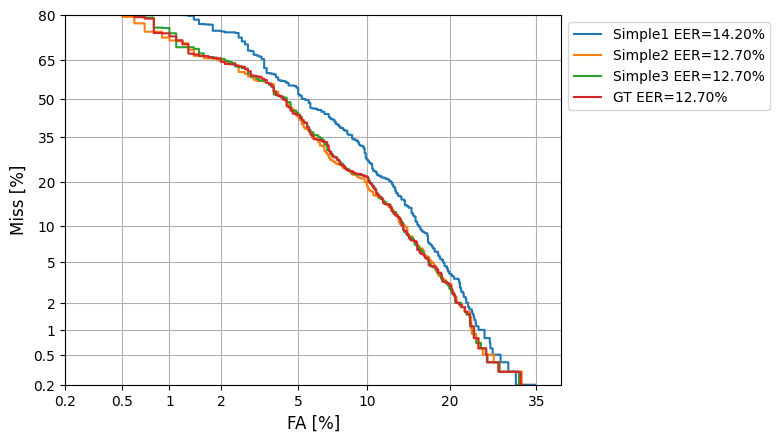

In [97]:
# Your code goes here
target_trial_scores_multi_gt = LLRs(x_test_target, x_enroll10, mu_gt, Sigma_ac_gt, Sigma_wc_gt)
nontar_trial_scores_multi_gt = LLRs(x_test_nontar, x_enroll10, mu_gt, Sigma_ac_gt, Sigma_wc_gt)

target_trial_scores_multi_simple1 = LLRs(x_test_target, x_enroll10, mu_simple1, Sigma_ac_simple1, Sigma_wc_simple1)
nontar_trial_scores_multi_simple1 = LLRs(x_test_nontar, x_enroll10, mu_simple1, Sigma_ac_simple1, Sigma_wc_simple1)
target_trial_scores_multi_simple2 = LLRs(x_test_target, x_enroll10, mu_simple2, Sigma_ac_simple2, Sigma_wc_simple2)
nontar_trial_scores_multi_simple2 = LLRs(x_test_nontar, x_enroll10, mu_simple2, Sigma_ac_simple2, Sigma_wc_simple2)
target_trial_scores_multi_simple3 = LLRs(x_test_target, x_enroll10, mu_simple3, Sigma_ac_simple3, Sigma_wc_simple3)
nontar_trial_scores_multi_simple3 = LLRs(x_test_nontar, x_enroll10, mu_simple3, Sigma_ac_simple3, Sigma_wc_simple3)

plot_det(target_trial_scores_multi_simple1, nontar_trial_scores_multi_simple1, label="Simple1")
plot_det(target_trial_scores_multi_simple2, nontar_trial_scores_multi_simple2, label="Simple2")
plot_det(target_trial_scores_multi_simple3, nontar_trial_scores_multi_simple3, label="Simple3")
plot_det(target_trial_scores_multi_gt, nontar_trial_scores_multi_gt, label="GT")

plt.show()

target_trial_scores_multi_EM1 = LLRs(x_test_target, x_enroll10, mu_EM1, Sigma_ac_EM1, Sigma_wc_EM1)
nontar_trial_scores_multi_EM1 = LLRs(x_test_nontar, x_enroll10, mu_EM1, Sigma_ac_EM1, Sigma_wc_EM1)
target_trial_scores_multi_EM2 = LLRs(x_test_target, x_enroll10, mu_EM2, Sigma_ac_EM2, Sigma_wc_EM2)
nontar_trial_scores_multi_EM2 = LLRs(x_test_nontar, x_enroll10, mu_EM2, Sigma_ac_EM2, Sigma_wc_EM2)
target_trial_scores_multi_EM3 = LLRs(x_test_target, x_enroll10, mu_EM3, Sigma_ac_EM3, Sigma_wc_EM3)
nontar_trial_scores_multi_EM3 = LLRs(x_test_nontar, x_enroll10, mu_EM3, Sigma_ac_EM3, Sigma_wc_EM3)

plot_det(target_trial_scores_multi_EM1, nontar_trial_scores_multi_EM1, label="Simple1")
plot_det(target_trial_scores_multi_EM2, nontar_trial_scores_multi_EM2, label="Simple2")
plot_det(target_trial_scores_multi_EM3, nontar_trial_scores_multi_EM3, label="Simple3")
plot_det(target_trial_scores_multi_gt, nontar_trial_scores_multi_gt, label="GT")